In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from common.data_frame_columns import PM10, PM2_5, PM1
from common.date_time_helper import convert_to_datetime
from common.endpoints_urls import endpoints_config
from common.working_dataset_config import working_datetime, test_date_time_strings
from data_management.data_crawler import DataManager
from data_management.data_reshaper import reshape_data, prepare_dataset, flatten_data
from data_management.labeled_data_generator import LabeledDataGenerator, DataLabel
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [9]:
date_strings = ['01.01.2021 00:00', '31.12.2023 23:59']
test_dates_string = ['01.01.2024 00:00', '30.04.2024 23:59']

training_dates = [convert_to_datetime(date_strings[0]), convert_to_datetime(date_strings[1])]
test_dates = [convert_to_datetime(test_dates_string[0]), convert_to_datetime(test_dates_string[1])]

datas = DataManager(True).get_all_endpoints_data(endpoints_config, update=False)

column = PM10
L = LabeledDataGenerator(column)

test_data = L.generate_labeled_data(datas[:1], test_dates[0], test_dates[1], 50)
single_data = L.generate_labeled_data(datas[:1], training_dates[0], training_dates[1], 50)
multi_data = L.generate_labeled_data(datas, training_dates[0], training_dates[1], 50)

Loading station data: Gronie  https://datahub.ki.agh.edu.pl/api/endpoints/70/data/
    # Minimal data: 2022-07-13 23:38:02+00:00
    # Maximal data: 2024-05-10 16:16:39+00:00
Loading station data: Urząd Gminy  https://datahub.ki.agh.edu.pl/api/endpoints/71/data/
    # Minimal data: 2023-10-28 07:17:18+00:00
    # Maximal data: 2024-05-10 16:15:37+00:00
Loading station data: Młynne  https://datahub.ki.agh.edu.pl/api/endpoints/72/data/
    # Minimal data: 2022-02-12 21:11:18+00:00
    # Maximal data: 2024-05-10 16:15:59+00:00
Loading station data: Sucharskiego  https://datahub.ki.agh.edu.pl/api/endpoints/73/data/
    # Minimal data: 2021-10-07 19:41:43+00:00
    # Maximal data: 2024-05-10 16:19:11+00:00
Loading station data: Twardowskiego  https://datahub.ki.agh.edu.pl/api/endpoints/74/data/
    # Minimal data: 2021-10-07 20:59:56+00:00
    # Maximal data: 2024-05-10 16:20:04+00:00
Loading station data: Konopnickiej  https://datahub.ki.agh.edu.pl/api/endpoints/75/data/
    # Minimal data

In [10]:
class MyBayesClassifier:
    def __init__(self, ):
        self.xdxd = GaussianNB()

    def fit_data(self, labeled_data, column):
        X, y = prepare_dataset(labeled_data, column)
        X = flatten_data(X)
        self.xdxd.fit(X, y)

    def test_accuracy(self, labeled_data, column):
        X_set, y_set = prepare_dataset(labeled_data, column)
        X_set = flatten_data(X_set)
        predicted = self.xdxd.predict(X_set)
        accuracy = accuracy_score(y_set, predicted)
        precision = precision_score(y_set, predicted, average='weighted')
        recall = recall_score(y_set, predicted, average='weighted')
        f1 = f1_score(y_set, predicted, average='weighted', zero_division=np.nan)

        return accuracy, precision, recall, f1

In [11]:
from matplotlib import pyplot as plt

config_list = [
    {
        'name': 'nbg_SDSC',
        'columns': [PM10],
        'training_datas': single_data,
        'test_datas': test_data
    },
    {
        'name': 'nbg_SDMC',
        'columns': [PM10, PM1, PM2_5],
        'training_datas': single_data,
        'test_datas': test_data
    },
    {
        'name': 'nbg_MDSC',
        'columns': [PM10],
        'training_datas': multi_data,
        'test_datas': test_data
    },
    {
        'name': 'nbg_MDMC',
        'columns': [PM10, PM1, PM2_5],
        'training_datas': multi_data,
        'test_datas': test_data
    }
]
final_result = []
for config in config_list:
    knn = MyBayesClassifier()
    knn.fit_data(config['training_datas'], config['columns'])
    accuracy, precision, recall, f1 = knn.test_accuracy(config['test_datas'], config['columns'])
    
        
    print({'name': config['name'], 'accuracy': accuracy, 'precision': precision, 'recall': recall,
           'f1': f1})

    final_result.append({'name': config['name'], 
                         'acc': accuracy,
                         'prec': precision,
                         'recall': recall,
                         'f1': f1, })


{'name': 'nbg_SDSC', 'accuracy': 0.6039603960396039, 'precision': 0.7088429431178412, 'recall': 0.6039603960396039, 'f1': 0.6083834775729389}
{'name': 'nbg_SDMC', 'accuracy': 0.6039603960396039, 'precision': 0.7732412714955706, 'recall': 0.6039603960396039, 'f1': 0.6274150326219795}
{'name': 'nbg_MDSC', 'accuracy': 0.801980198019802, 'precision': 0.7241262587797241, 'recall': 0.801980198019802, 'f1': 0.7590428629846714}
{'name': 'nbg_MDMC', 'accuracy': 0.8118811881188119, 'precision': 0.7308905553628139, 'recall': 0.8118811881188119, 'f1': 0.7663018933472294}


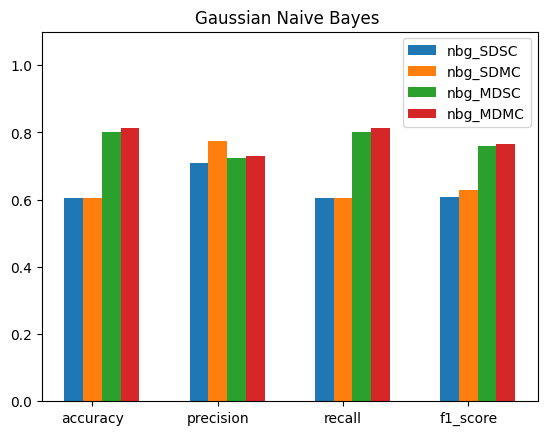

In [12]:
x_labels = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(x_labels))
width = 0.15 
multiplier = 0
fig, ax = plt.subplots()

accuracies = [x['acc'] for x in final_result]


for result in final_result:
    offset = width * multiplier
    rects = ax.bar(x + offset, [result['acc'], result['prec'], result['recall'], result['f1']], width, label=result['name'])
    # ax.bar_label(rects, padding=4)
    multiplier += 1
    
ax.set_title('Gaussian Naive Bayes ')
ax.set_xticks(x + width, x_labels)
ax.legend(loc='upper right', )
ax.set_ylim(0, 1.1)
plt.show()



In [13]:
for result in final_result:
    for key, value in result.items():
        print(f'{key} : {value}')
    print()

name : nbg_SDSC
acc : 0.6039603960396039
prec : 0.7088429431178412
recall : 0.6039603960396039
f1 : 0.6083834775729389

name : nbg_SDMC
acc : 0.6039603960396039
prec : 0.7732412714955706
recall : 0.6039603960396039
f1 : 0.6274150326219795

name : nbg_MDSC
acc : 0.801980198019802
prec : 0.7241262587797241
recall : 0.801980198019802
f1 : 0.7590428629846714

name : nbg_MDMC
acc : 0.8118811881188119
prec : 0.7308905553628139
recall : 0.8118811881188119
f1 : 0.7663018933472294


In [14]:
'''
name : nbg_SDSC
acc : 0.5165562913907285
prec : 0.6870871468782717
recall : 0.5165562913907285
f1 : 0.5348976620573791

name : nbg_SDMC
acc : 0.5049668874172185
prec : 0.6791002488100161
recall : 0.5049668874172185
f1 : 0.5315880809217833

name : nbg_MDSC
acc : 0.6440397350993378
prec : 0.715151143107533
recall : 0.6440397350993378
f1 : 0.6642711875260443

name : nbg_MDMC
acc : 0.7334437086092715
prec : 0.7480083804852642
recall : 0.7334437086092715
f1 : 0.7386712002269304
'''

'\nname : nbg_SDSC\nacc : 0.5165562913907285\nprec : 0.6870871468782717\nrecall : 0.5165562913907285\nf1 : 0.5348976620573791\n\nname : nbg_SDMC\nacc : 0.5049668874172185\nprec : 0.6791002488100161\nrecall : 0.5049668874172185\nf1 : 0.5315880809217833\n\nname : nbg_MDSC\nacc : 0.6440397350993378\nprec : 0.715151143107533\nrecall : 0.6440397350993378\nf1 : 0.6642711875260443\n\nname : nbg_MDMC\nacc : 0.7334437086092715\nprec : 0.7480083804852642\nrecall : 0.7334437086092715\nf1 : 0.7386712002269304\n'